In [1]:
from utils import train_utils, data_utils, anchor_utils, bbox_utils
import tensorflow as tf
from config import *
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL']= '2'

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as error:
        print(error)

1 Physical GPUs, 1 Logical GPUs


In [4]:
model, _, _, _ = train_utils.get_model()

Model: YOLOv4


In [5]:
import tensorflow as tf
from config import *
import numpy as np
from utils import aug_utils, bbox_utils, anchor_utils

class DataLoader():
    def __init__(self, dtype=DTYPE, batch_size=GLOBAL_BATCH_SIZE, anchors=ANCHORS, num_anchors=NUM_ANCHORS, num_classes=NUM_CLASSES,
                 image_size=IMAGE_SIZE, strides=STRIDES, positive_iou_threshold=POSITIVE_IOU_THRESHOLD, max_bboxes=MAX_BBOXES):
                 
        self.batch_size = batch_size
        self.num_anchors = num_anchors
        self.len_anchors = len(ANCHORS)
        self.num_classes = num_classes
        self.image_size = image_size
        self.strides = np.array(strides)
        self.scales = image_size//self.strides
        self.anchors = anchor_utils.get_anchors_xywh(anchors, self.strides, self.image_size)
        self.positive_iou_threshold = positive_iou_threshold
        self.max_bboxes = max_bboxes
        self.dtype = dtype
        self._length = {}

    def __call__(self, split, use_tfrecord=True, use_label=False):
        if self.dtype == 'voc':
            from datasets.voc_dataset import Dataset
        elif self.dtype == 'coco':
            from datasets.coco_dataset import Dataset
        elif self.dtype == 'custom':
            from datasets.custom_dataset import Dataset
        elif self.dtype == 'raw':
            from datasets.raw_dataset import Dataset
        dataset = Dataset(split)

        data = dataset.load(use_tfrecord)
        self._length[split] = dataset.length
        data = data.cache()
        
        if split == 'train':
            data = data.shuffle(buffer_size = min(self.length(split) * 3, 200000)) # ram memory limit
            data = data.map(aug_utils.tf_augmentation, num_parallel_calls=-1)
        
        data = data.map(self.tf_preprocessing, num_parallel_calls=-1)
        data = data.padded_batch(self.batch_size, padded_shapes=get_padded_shapes(), padding_values=get_padding_values(), drop_remainder=True)
        
        # data = data.map(lambda x, y: self.py_labels_to_grids(x, y, use_label), num_parallel_calls=-1).prefetch(1)
        data = data.map(lambda x, y: self.tf_labels_to_grids(x, y, use_label), num_parallel_calls=-1).prefetch(1)
        return data
    
    def length(self, split):
        return self._length[split]
    
    def py_labels_to_grids(self, image, labels, use_label=False):
        grids = tf.py_function(self.labels_to_grids, [labels], [tf.float32]*self.len_anchors)
        if use_label:
            return image, *grids, labels
        return image, *grids
    
    @tf.function
    def tf_preprocessing(self, image, labels, width, height):
        image, labels = aug_utils.tf_resize_padding(image, labels, width, height, self.image_size)
        labels = bbox_utils.xyxy_to_xywh(labels, True) 
        labels = tf.concat([labels[..., :4], tf.where(tf.reduce_sum(labels[..., 2:4], -1, keepdims=True)==0, 0., 1.), labels[..., 4:5]], -1)
        return tf.cast(image, tf.float32)/255., labels
    
    @tf.function
    def tf_labels_to_grids(self, image, labels, use_label):
        grids = self.labels_to_grids(labels)
        if use_label:
            return image, *grids, labels
        return image, *grids
    
    @tf.function
    def labels_to_grids(self, labels):
        # return tf.zeros((self.batch_size, 52, 52, 3, 85)), tf.zeros((self.batch_size, 26, 26, 3, 85)), tf.zeros((self.batch_size, 13, 13, 3, 85))
        wh = labels[..., 2:4]
        conf = labels[..., 4:5]
        onehot = tf.where(tf.cast(conf, tf.bool), tf.one_hot(tf.cast(labels[..., 5], dtype=tf.int32), NUM_CLASSES), 0.)

        grids = []
        anchor_xy = [tf.reshape(anchor[..., :2], [-1,2]) for anchor in self.anchors]
        anchor_wh = [tf.reshape(anchor[..., 2:], [-1,2]) for anchor in self.anchors]

        center_anchors = tf.concat([tf.concat([anchor_xy[i] + 0.5, anchor_wh[i]], -1) * self.strides[i] for i in range(self.len_anchors)], 0)
        # base_anchor_xy = tf.concat([tf.concat([anchor_xy[i], anchor_wh[i]], -1) * self.strides[i] for i in range(self.len_anchors)], 0)
        base_anchor_xy = tf.concat([tf.concat([anchor_xy[i]], -1) * self.strides[i] for i in range(self.len_anchors)], 0)
        ious = bbox_utils.bbox_iou(center_anchors[:, None], labels[:, None, ..., :4])

        # assign maximum label
        maximum_positive_ious = tf.where(tf.greater_equal(ious, self.positive_iou_threshold), ious, 0.)

        # assign minimum label
        best_anchor_iou = tf.reduce_max(ious, -2, keepdims=True)
        minimum_positive_ious = tf.where(tf.logical_and(ious == best_anchor_iou, ious > 0), best_anchor_iou, 0.)
    
        # join minimum, maximum label
        joined_ious = tf.where(tf.cast(minimum_positive_ious, tf.bool), minimum_positive_ious, maximum_positive_ious)
        joined_positive_mask = tf.cast(tf.reduce_any(tf.cast(joined_ious, tf.bool), -1, keepdims=True), tf.float32)

        # assigned_labels = tf.concat([tf.tile(base_anchor_xy[None], [self.batch_size, 1,1]), tf.gather(tf.concat([ conf, onehot], -1), tf.argmax(joined_ious, -1), batch_dims=1) * joined_positive_mask], -1)
        assigned_labels = tf.concat([tf.tile(base_anchor_xy[None], [self.batch_size, 1,1]), tf.gather(tf.concat([wh, conf, onehot], -1), tf.argmax(joined_ious, -1), batch_dims=1) * joined_positive_mask], -1)

        for i in range(self.len_anchors):
            scale = self.scales[i]
            start = 0 if i==0 else tf.reduce_sum((self.image_size//self.strides[:i])**2 * self.len_anchors)
            end = start + (scale)**2 * self.len_anchors
            grids += [tf.reshape(assigned_labels[:, start:end], [self.batch_size, scale, scale, self.len_anchors, -1])]

        return grids
    
def get_padded_shapes():
    return [None, None, None], [MAX_BBOXES, None]

def get_padding_values():
    return tf.constant(0, tf.float32), tf.constant(0, tf.float32)

In [6]:
# dataloader = data_utils.DataLoader(batch_size=BATCH_SIZE)
dataloader = DataLoader(batch_size=BATCH_SIZE)
test_dataset = dataloader('val', use_label=True)

/home/hs/anaconda3/envs/tf28/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: custom val
./data/custom/val.tfrecord is exist


In [7]:
data = next(iter(test_dataset))

In [8]:
images, s_grids, m_grids, l_grids, labels = data

In [9]:
def draw(image, p1, p2, color, width, box=True):
    if box:
        cv2.rectangle(image, p1,p2, color, width)
    else:
        c = ((p1 + p2)*0.5).astype(np.int32)
        cv2.circle(image, c, width, color, width)

[288. 144.  88.  98.   1.   0.   1.   0.   0.   0.   0.]
[288. 144.  88.  98.   1.   0.   1.   0.   0.   0.   0.]
0 2 0 1


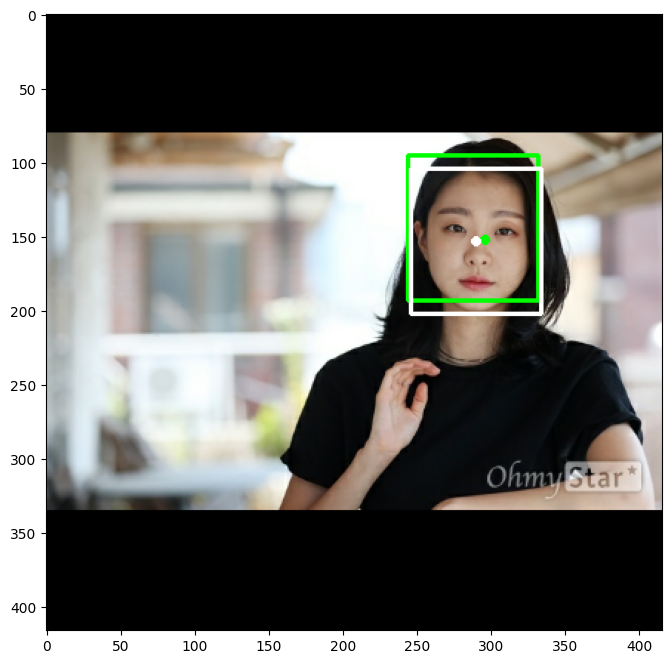

In [10]:
plt.figure(figsize=(8,8))
c_image = np.zeros((416,416,3), np.float32)
for i, (image, s_grid, m_grid, l_grid, label) in enumerate(zip(images.numpy()*255, s_grids, m_grids, l_grids, labels)):
    if i==0:
        image = image.astype(np.int32)

        ss = 0 
        for y, y_grid in enumerate(s_grid.numpy()):
            for x, x_grid in enumerate(y_grid):
                for a, grid in enumerate(x_grid):
                    if grid[4] != 0:
                        p1 = (grid[..., :2] - 0.5 * grid[..., 2:4]).astype(np.int32)
                        p2 = (grid[..., :2] + 0.5 * grid[..., 2:4]).astype(np.int32)
                        draw(image, p1, p2, (255, 0, 0), 2)
                        cv2.circle(image, (x*8+4, y*8+4), 2, (255, 0, 0), 2)
                        ss += 1
                        c_image[y*8+4, x*8+4] = (255., 0., 0.)
                        print(grid)
        
        mm = 0
        for y, y_grid in enumerate(m_grid.numpy()):
            for x, x_grid in enumerate(y_grid):
                for a, grid in enumerate(x_grid):
                    if grid[4] != 0:
                        p1 = (grid[..., :2] - 0.5 * grid[..., 2:4]).astype(np.int32)
                        p2 = (grid[..., :2] + 0.5 * grid[..., 2:4]).astype(np.int32)
                        draw(image, p1, p2, (0, 255, 0), 2)
                        cv2.circle(image, (x*16+8, y*16+8), 2, (0, 255, 0), 2)
                        mm += 1
                        c_image[y*16+8, x*16+8] = (0., 255., 0.)
                        print(grid)

        ll = 0
        for y, y_grid in enumerate(l_grid.numpy()):
            for x, x_grid in enumerate(y_grid):
                for a, grid in enumerate(x_grid):
                    if grid[4] != 0:
                        print(grid)
                        p1 = (grid[..., :2] - 0.5 * grid[..., 2:4]).astype(np.int32)
                        p2 = (grid[..., :2] + 0.5 * grid[..., 2:4]).astype(np.int32)
                        draw(image, p1, p2, (0, 0, 255), 2)
                        cv2.circle(image, (x*32+16, y*32+16), 2, (0, 0, 255), 2)
                        ll += 1
                        c_image[y*32+16, x*32+16] = (0., 0., 255.)
                        print(grid)

        gg = 0
        for g in label.numpy():
            if g[4] != 0:
                cv2.circle(image, g[..., :2].astype(np.int32), 2, (255, 255, 255), 2)
                p1 = (g[..., :2] - 0.5 * g[..., 2:4]).astype(np.int32)
                p2 = (g[..., :2] + 0.5 * g[..., 2:4]).astype(np.int32)
                draw(image, p1, p2, (255, 255, 255), 2)
                gg += 1
        plt.imshow(image)
        print(ss, mm, ll, gg)
        break
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


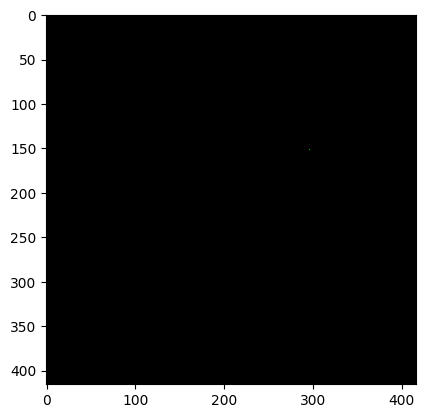

In [11]:
plt.imshow(c_image)
plt.show()

In [12]:
out = model(images[0:1])

In [13]:
anchors = anchor_utils.get_anchors_xywh(ANCHORS, STRIDES, IMAGE_SIZE)

1


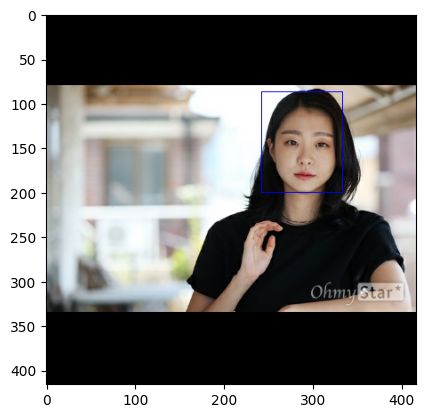

In [24]:
count = 0
i = (images[0].numpy()*255).astype(np.uint8)
for g, anchor, stride in zip(out, anchors, STRIDES):
    raw_bbox = g[..., :4]
    raw_conf = g[..., 4:5]
    raw_prob = g[..., 5:]
    pred_xy = tf.sigmoid(raw_bbox[..., :2]) + anchor[..., :2]
    pred_wh = tf.exp(raw_bbox[..., 2:4]) * anchor[..., 2:4]
    pred_bbox = tf.concat([pred_xy, pred_wh], -1) * stride
    pred_conf = tf.sigmoid(raw_conf)
    pred_prob = tf.argmax(tf.sigmoid(raw_prob), -1)[..., None]

    best_c = 0.
    best_box = [[0,0],[0,0]]

    for b, c, p in zip(pred_bbox.numpy().reshape(-1, 4), pred_conf.numpy().reshape(-1, 1), pred_prob.numpy().reshape(-1, 1)):
        
        if c>0.4:
            p1 = (b[:2] - 0.5 * b[2:4]).astype(np.int32)
            p2 = (b[:2] + 0.5 * b[2:4]).astype(np.int32)
            cv2.rectangle(i, p1, p2, (255, 0, 0), 1)
            count += 1
            if best_c < c:
                best_c = c
                best_box = [p1, p2]

    cv2.rectangle(i, best_box[0], best_box[1], (0, 0, 255), 1)
print(count)
plt.imshow(i)
plt.show()

[0.15359923]
[0.21051572]
[0.15195565]
[0.19913505]
4


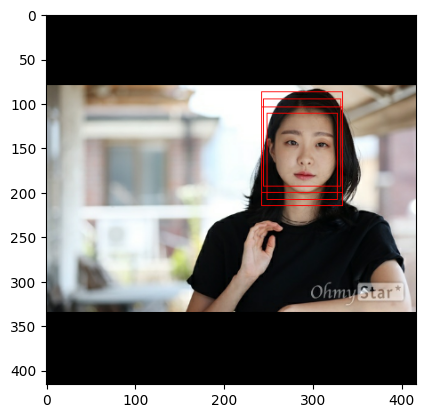

In [27]:
from utils import post_processing
anchors_flat = list(map(lambda x: tf.reshape(x, [-1,4]), anchor_utils.get_anchors_xywh(ANCHORS, STRIDES, IMAGE_SIZE)))

batch_processed_preds = post_processing.prediction_to_bbox(out, anchors_flat, 1, STRIDES, NUM_CLASSES, IMAGE_SIZE)
count = 0
best_cc = 0
best_bbox = [[0,0], [0,0]]
i = (images[0].numpy()*255).astype(np.uint8)

for pred in batch_processed_preds[0].numpy():
    bb = pred[..., :4]
    cc = pred[..., 4:5]
    pp = pred[..., 5:]

    pp1 = bb[..., :2].astype(np.int32)
    pp2 = bb[..., 2:4].astype(np.int32)
    if cc>0.1:
        print(cc)
        cv2.rectangle(i, pp1, pp2, (255, 0, 0), 1)
        count += 1
    if best_cc < cc:
        best_cc = cc
        best_bbox = [pp1, pp2]
cv2.rectangle(i, best_box[0], best_box[1], (0, 0, 255), 1)
print(count)
plt.imshow(i)
plt.show()

In [16]:
batch_processed_preds

<tf.Tensor: shape=(1, 10647, 6), dtype=float32, numpy=
array([[[0.0000000e+00, 0.0000000e+00, 2.6803528e+01, 2.7611971e+01,
         3.1408701e-02, 1.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 2.9270788e+01, 3.5111111e+01,
         3.9586406e-02, 3.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 5.9016182e+01, 3.1899870e+01,
         3.7231006e-02, 5.0000000e+00],
        ...,
        [3.2643811e+02, 3.1750766e+02, 4.1600000e+02, 4.1600000e+02,
         2.2285953e-02, 0.0000000e+00],
        [2.9445630e+02, 2.8749371e+02, 4.1600000e+02, 4.1600000e+02,
         1.0375159e-02, 1.0000000e+00],
        [3.2055493e+02, 1.5889650e+02, 4.1600000e+02, 4.1600000e+02,
         1.6240027e-02, 4.0000000e+00]]], dtype=float32)>

In [ ]:
triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to
이거 에러 잡기

In [19]:
tf.exp(-0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=0.60653067>